# ***Problem Statement***

Traditional chatbots struggle with context-aware question answering where they need to:
- Understand and remember story context
- Process natural language questions
- Provide accurate answers based on stored information

# ***Objective***

Build an intelligent chatbot that can:
1. Process story contexts and questions
2. Learn relationships between entities and locations
3. Answer questions accurately based on stored memories
4. Handle simple reasoning tasks (e.g., "Is John in the kitchen?")

# ***Key Challenges Addressed***
- Context retention and memory management
- Natural language understanding
- Sequence-to-sequence learning
- Multi-modal input processing (stories + questions)


# ***ENVIRONMENT SETUP & LIBRARY IMPORTS***

In [1]:
# Install required packages
!pip install keras tensorflow numpy pandas matplotlib

# Import essential libraries
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Keras/TensorFlow imports for deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (Embedding, Input, Activation, Dense,
                                   Permute, Dropout, add, dot, concatenate, LSTM)
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

✅ All libraries imported successfully!
TensorFlow version: 2.19.0


# ***Data Structure Overview***

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with open("/content/drive/MyDrive/Chatbot_NLP/Train-Data Set.txt", "rb") as fp:
    Train_data = pickle.load(fp)

In [4]:
with open("/content/drive/MyDrive/Chatbot_NLP/Test-Data Set.txt", "rb") as fp:
    Test_data = pickle.load(fp)

In [5]:
print(Test_data[:5])

[(['Mary', 'got', 'the', 'milk', 'there', '.', 'John', 'moved', 'to', 'the', 'bedroom', '.'], ['Is', 'John', 'in', 'the', 'kitchen', '?'], 'no'), (['Mary', 'got', 'the', 'milk', 'there', '.', 'John', 'moved', 'to', 'the', 'bedroom', '.', 'Mary', 'discarded', 'the', 'milk', '.', 'John', 'went', 'to', 'the', 'garden', '.'], ['Is', 'John', 'in', 'the', 'kitchen', '?'], 'no'), (['Mary', 'got', 'the', 'milk', 'there', '.', 'John', 'moved', 'to', 'the', 'bedroom', '.', 'Mary', 'discarded', 'the', 'milk', '.', 'John', 'went', 'to', 'the', 'garden', '.', 'Daniel', 'moved', 'to', 'the', 'bedroom', '.', 'Daniel', 'went', 'to', 'the', 'garden', '.'], ['Is', 'John', 'in', 'the', 'garden', '?'], 'yes'), (['Mary', 'got', 'the', 'milk', 'there', '.', 'John', 'moved', 'to', 'the', 'bedroom', '.', 'Mary', 'discarded', 'the', 'milk', '.', 'John', 'went', 'to', 'the', 'garden', '.', 'Daniel', 'moved', 'to', 'the', 'bedroom', '.', 'Daniel', 'went', 'to', 'the', 'garden', '.', 'Daniel', 'travelled', 'to', 

In [6]:
def analyze_data_structure(train_data, test_data):
    """Analyze and display data characteristics"""

    print(f"Training data type: {type(train_data)}")
    print(f"Test data type: {type(test_data)}")
    print(f"Training samples: {len(train_data)}")
    print(f"Test samples: {len(test_data)}")

    # Display sample data point
    if len(train_data) > 0:
        print(f"\n📝 Sample Training Example:")
        print(f"Story: {' '.join(train_data[0][0])}")
        print(f"Question: {' '.join(train_data[0][1])}")
        print(f"Answer: {train_data[0][2]}")

    return train_data, test_data

Train_data, Test_data = analyze_data_structure(Train_data, Test_data)

Training data type: <class 'list'>
Test data type: <class 'list'>
Training samples: 10000
Test samples: 1000

📝 Sample Training Example:
Story: Mary moved to the bathroom . Sandra journeyed to the bedroom .
Question: Is Sandra in the hallway ?
Answer: no


# ***VOCABULARY BUILDING & TEXT PREPROCESSING***
Vocabulary Construction

Building a comprehensive vocabulary from all text data:
1. Extract unique words from stories and questions
2. Add answer tokens ('yes', 'no')
3. Create word-to-index mapping using Keras Tokenizer

In [7]:
def build_vocabulary(train_data, test_data):
    """Build vocabulary from all available text data"""

    print("🔤 Building vocabulary...")

    # Initialize vocabulary set
    vocab = set()
    all_data = test_data + train_data

    # Extract vocabulary from stories and questions
    for story, question, answer in all_data:
        vocab = vocab.union(set(story))
        vocab = vocab.union(set(question))

    # Add answer vocabulary
    vocab.add('yes')
    vocab.add('no')

    print(f"📈 Vocabulary Statistics:")
    print(f"Total unique words: {len(vocab)}")
    print(f"Sample words: {list(vocab)[:10]}")

    return vocab, all_data

vocab, all_data = build_vocabulary(Train_data, Test_data)

🔤 Building vocabulary...
📈 Vocabulary Statistics:
Total unique words: 37
Sample words: ['moved', 'Mary', 'dropped', 'picked', 'got', 'garden', 'Daniel', 'Sandra', 'bathroom', 'travelled']


Sequence Length Analysis:
Max story length: 156
Average story length: 38.50
Max question length: 6
Average question length: 6.00


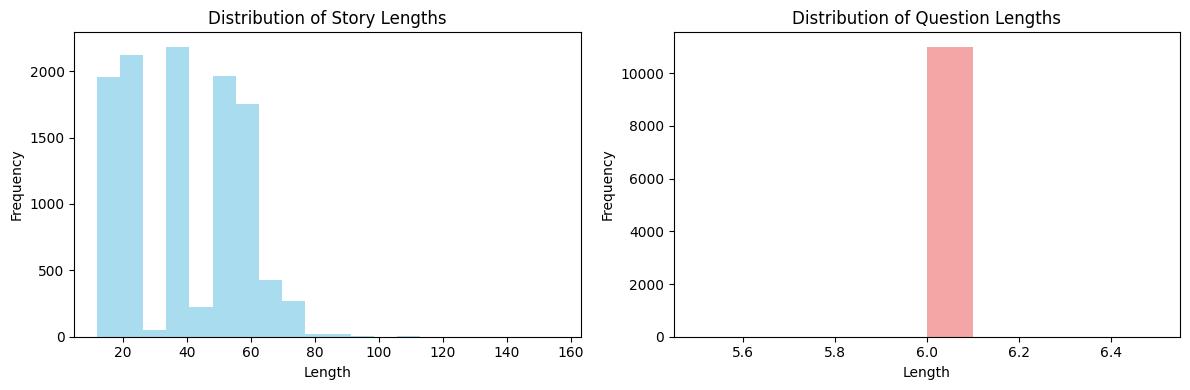

In [8]:
def analyze_sequence_lengths(all_data):
    """Analyze sequence lengths for padding purposes"""

    story_lengths = [len(data[0]) for data in all_data]
    question_lengths = [len(data[1]) for data in all_data]

    max_story_len = max(story_lengths)
    max_ques_len = max(question_lengths)

    print(f"Sequence Length Analysis:")
    print(f"Max story length: {max_story_len}")
    print(f"Average story length: {np.mean(story_lengths):.2f}")
    print(f"Max question length: {max_ques_len}")
    print(f"Average question length: {np.mean(question_lengths):.2f}")

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.hist(story_lengths, bins=20, alpha=0.7, color='skyblue')
    plt.title('Distribution of Story Lengths')
    plt.xlabel('Length')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(question_lengths, bins=10, alpha=0.7, color='lightcoral')
    plt.title('Distribution of Question Lengths')
    plt.xlabel('Length')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return max_story_len, max_ques_len

max_story_len, max_ques_len = analyze_sequence_lengths(all_data)

# ***TEXT VECTORIZATION & TOKENIZATION***
Text Vectorization Process

Converting text to numerical format:
1. Create tokenizer with no filters to preserve punctuation
2. Fit tokenizer on vocabulary
3. Convert text sequences to integer sequences
4. Pad sequences to uniform length

In [9]:
def setup_tokenizer(vocab):
    """Initialize and configure tokenizer"""

    tokenizer = Tokenizer(filters='')  # No filtering to preserve all tokens
    tokenizer.fit_on_texts(vocab)

    vocab_len = len(vocab) + 1  # +1 for padding token

    print(f"🎯 Tokenizer Configuration:")
    print(f"Vocabulary size: {vocab_len}")
    print(f"Sample word indices: {dict(list(tokenizer.word_index.items())[:10])}")

    return tokenizer, vocab_len

tokenizer, vocab_len = setup_tokenizer(vocab)

🎯 Tokenizer Configuration:
Vocabulary size: 38
Sample word indices: {'moved': 1, 'mary': 2, 'dropped': 3, 'picked': 4, 'got': 5, 'garden': 6, 'daniel': 7, 'sandra': 8, 'bathroom': 9, 'travelled': 10}


In [10]:
tokenizer.word_index

{'moved': 1,
 'mary': 2,
 'dropped': 3,
 'picked': 4,
 'got': 5,
 'garden': 6,
 'daniel': 7,
 'sandra': 8,
 'bathroom': 9,
 'travelled': 10,
 'yes': 11,
 'is': 12,
 'john': 13,
 'down': 14,
 'bedroom': 15,
 'hallway': 16,
 '?': 17,
 'the': 18,
 'milk': 19,
 '.': 20,
 'in': 21,
 'put': 22,
 'office': 23,
 'up': 24,
 'football': 25,
 'discarded': 26,
 'journeyed': 27,
 'to': 28,
 'left': 29,
 'took': 30,
 'grabbed': 31,
 'apple': 32,
 'no': 33,
 'there': 34,
 'went': 35,
 'kitchen': 36,
 'back': 37}

In [11]:
def vectorize_stories(data, tokenizer, max_story_len, max_ques_len):
    """Convert text data to numerical vectors"""

    print("🔢 Vectorizing text data...")

    X = []      # Stories
    Xq = []     # Questions
    Y = []      # Answers

    word_index = tokenizer.word_index

    for i, (story, query, answer) in enumerate(data):
        if i < 5: # Print for first 5 examples
            print(f"\nProcessing example {i+1}:")
            print(f"  Original Story: {story}")
            print(f"  Original Question: {query}")
            print(f"  Original Answer: {answer}")


        # Convert words to indices
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in query]

        if i < 5: # Print for first 5 examples
            print(f"  Story indices: {x}")
            print(f"  Question indices: {xq}")

        # One-hot encode answers
        y = np.zeros(len(word_index) + 1)
        y[word_index[answer]] = 1

        if i < 5: # Print for first 5 examples
            print(f"  Answer one-hot: {y}")


        X.append(x)
        Xq.append(xq)
        Y.append(y)

    # Pad sequences to uniform length
    X_padded = pad_sequences(X, maxlen=max_story_len)
    Xq_padded = pad_sequences(Xq, maxlen=max_ques_len)
    Y_array = np.array(Y)

    print(f"\n✅ Vectorization complete!")
    print(f"Stories shape: {X_padded.shape}")
    print(f"Questions shape: {Xq_padded.shape}")
    print(f"Answers shape: {Y_array.shape}")

    return X_padded, Xq_padded, Y_array


tokenizer, vocab_len = setup_tokenizer(vocab)
inputs_train, queries_train, answers_train = vectorize_stories(Train_data, tokenizer, max_story_len, max_ques_len)
inputs_test, queries_test, answers_test = vectorize_stories(Test_data, tokenizer, max_story_len, max_ques_len)

🎯 Tokenizer Configuration:
Vocabulary size: 38
Sample word indices: {'moved': 1, 'mary': 2, 'dropped': 3, 'picked': 4, 'got': 5, 'garden': 6, 'daniel': 7, 'sandra': 8, 'bathroom': 9, 'travelled': 10}
🔢 Vectorizing text data...

Processing example 1:
  Original Story: ['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'Sandra', 'journeyed', 'to', 'the', 'bedroom', '.']
  Original Question: ['Is', 'Sandra', 'in', 'the', 'hallway', '?']
  Original Answer: no
  Story indices: [2, 1, 28, 18, 9, 20, 8, 27, 28, 18, 15, 20]
  Question indices: [12, 8, 21, 18, 16, 17]
  Answer one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

Processing example 2:
  Original Story: ['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'Sandra', 'journeyed', 'to', 'the', 'bedroom', '.', 'Mary', 'went', 'back', 'to', 'the', 'bedroom', '.', 'Daniel', 'went', 'back', 'to', 'the', 'hallway', '.']
  Original Question: ['Is', 'Daniel', 'in', 'the', 'b

In [12]:
print(answers_train.shape)

(10000, 38)


In [13]:

print(answers_test.shape)

(1000, 38)


In [14]:
inputs_train.shape

(10000, 156)

In [15]:
print("First 5 samples of inputs_train:")
print(inputs_train[:5])

print("\nFirst 5 samples of queries_train:")
print(queries_train[:5])

print("\nFirst 5 samples of answers_train:")
print(answers_train[:5])

First 5 samples of inputs_train:
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   2  1 28 18  9 20  8 27 28 18 15 20]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  2  1 28 18  9 20  8 27 28 18 15 20  2 35
  37 28 18 15 20  7 35 37 28 18 16 20]
 

# ***MODEL ARCHITECTURE & APPROACH***

This section details the architecture of the improved Memory Network model designed for context-aware question answering.

Key Components:
1. **Input Encoders**: Process stories with different representations, now with **L2 Regularization** and **Batch Normalization**.
   - Memory encoder (m): For storing contextual information.
   - Context encoder (c): For response generation.
2. **Question Encoder**: Processes question sequences, also with **L2 Regularization** and **Batch Normalization**.
3. **Attention Mechanism**:
   - Computes attention between story and question.
   - Uses dot-product attention with softmax.
4. **Response Generation**:
   - Combines attention weights with context.
   - Uses a stack of **Bidirectional LSTM** and **GRU** layers for enhanced sequential processing and **L2 Regularization**.
   - Dense layer for final classification with **L2 Regularization**.

### Architecture Flow:
Story → [Input Encoders (with Reg. & BN)] → Memory Representations
Question → [Question Encoder (with Reg. & BN)] → Question Representation
[Memory × Question] → Attention Weights
[Attention Weights + Context Representation] → Response
Response + Question Representation → [Bidirectional LSTM + GRU (with Reg.)] → Processed Representation
Processed Representation → [Dense Layer (with Reg.)] → Answer Probability Distribution → [Softmax] → Final Answer

In [16]:
# IMPROVED MODEL ARCHITECTURE
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Bidirectional, GRU, BatchNormalization

def build_improved_memory_network(vocab_len, max_story_len, max_ques_len,
                                embedding_dim=128, l2_reg=0.001):
    """Build an improved Memory Network architecture for better accuracy"""

    print("🏗️ Building Improved Memory Network Architecture...")

    # Input layers
    input_sequence = Input((max_story_len,), name='story_input')
    question = Input((max_ques_len,), name='question_input')

    # Enhanced story encoders with regularization
    input_encoder_m = Sequential([
        Embedding(input_dim=vocab_len, output_dim=embedding_dim,
                 input_length=max_story_len,
                 embeddings_regularizer=l2(l2_reg),
                 name='memory_embedding'),
        BatchNormalization(),
        Dropout(0.3, name='memory_dropout')
    ], name='memory_encoder')

    input_encoder_c = Sequential([
        Embedding(input_dim=vocab_len, output_dim=max_ques_len,
                 input_length=max_story_len,
                 embeddings_regularizer=l2(l2_reg),
                 name='context_embedding'),
        BatchNormalization(),
        Dropout(0.3, name='context_dropout')
    ], name='context_encoder')

    # Enhanced question encoder
    question_encoder = Sequential([
        Embedding(input_dim=vocab_len, output_dim=embedding_dim,
                 input_length=max_ques_len,
                 embeddings_regularizer=l2(l2_reg),
                 name='question_embedding'),
        BatchNormalization(),
        Dropout(0.3, name='question_dropout')
    ], name='question_encoder')

    # Encode inputs
    input_encoded_m = input_encoder_m(input_sequence)
    input_encoded_c = input_encoder_c(input_sequence)
    question_encoded = question_encoder(question)

    # Attention mechanism (unchanged - already optimal)
    match = dot([input_encoded_m, question_encoded], axes=(2, 2), name='attention_dot')
    match = Activation('softmax', name='attention_weights')(match)

    # Response generation
    response = add([match, input_encoded_c], name='response_combination')
    response = Permute((2, 1), name='response_permute')(response)

    # IMPROVED: Bidirectional LSTM + GRU stack
    answer = concatenate([response, question_encoded], name='final_concatenation')
    answer = Bidirectional(LSTM(64, return_sequences=True,
                              kernel_regularizer=l2(l2_reg)))(answer)
    answer = GRU(32, kernel_regularizer=l2(l2_reg))(answer)
    answer = Dropout(0.5, name='final_dropout')(answer)
    answer = Dense(vocab_len, kernel_regularizer=l2(l2_reg), name='output_dense')(answer)
    answer = Activation('softmax', name='final_activation')(answer)

    model = Model([input_sequence, question], answer, name='improved_memory_network')
    return model

# IMPROVED COMPILATION WITH ADAM OPTIMIZER
def compile_improved_model(model, learning_rate=0.001):
    """Compile improved model with Adam optimizer"""

    # Adam optimizer generally performs better than RMSprop
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', 'top_k_categorical_accuracy']  # Added top-k accuracy
    )

    print("✅ Improved model compiled successfully!")
    return model

# Build and compile the improved model
improved_model = build_improved_memory_network(vocab_len, max_story_len, max_ques_len)
improved_model = compile_improved_model(improved_model)

# Display the model summary
improved_model.summary()

🏗️ Building Improved Memory Network Architecture...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


✅ Improved model compiled successfully!


Model: "improved_memory_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ story_input         │ (None, 156)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_input      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ memory_encoder      │ (None, 156, 128)  │      5,376 │ story_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_encoder    │ (None, 6, 128)    │      5,376 │ question_input[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_dot (Dot) │ (None, 156, 6)    │          0 │ memory_encoder[0… │
│                     │                   │            │ question_encoder… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 156, 6)    │          0 │ attention_dot[0]… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_encoder     │ (None, 156, 6)    │        252 │ story_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ response_combinati… │ (None, 156, 6)    │          0 │ attention_weight… │
│ (Add)               │                   │            │ context_encoder[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ response_permute    │ (None, 6, 156)    │          0 │ response_combina… │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_concatenation │ (None, 6, 284)    │          0 │ response_permute… │
│ (Concatenate)       │                   │            │ question_encoder… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 6, 128)    │    178,688 │ final_concatenat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 32)        │     15,552 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_dropout       │ (None, 32)        │          0 │ gru[0][0]         │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 38)        │      1,254 │ final_dropout[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_activation    │ (None, 38)        │          0 │ output_dense[0][… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 206,498 (806.63 KB)

 Trainable params: 205,974 (804.59 KB)

 Non-trainable params: 524 (2.05 KB)

# ***NLP PIPELINE & WORKFLOW OPTIMIZATION***
Training Strategy:
1. **Batch Processing**: Efficient memory usage (Increased batch size to 64)
2. **Early Stopping**: Prevent overfitting (Increased patience to 10, added min_delta)
3. **Model Checkpointing**: Save best weights
4. **Learning Rate Scheduling**: Adaptive learning (Exponential decay and ReduceLROnPlateau)
5. **Shuffling**: Important for better training

Monitoring Metrics:
- Training/Validation Loss
- Training/Validation Accuracy
- Top-K Categorical Accuracy (Added metric)
- Convergence Analysis (Visualized with loss plots)

🚀 Starting improved model training...
Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4609 - loss: 2.3188 - top_k_categorical_accuracy: 0.9087
Epoch 1: val_accuracy improved from -inf to 0.49700, saving model to best_improved_chatbot.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.4611 - loss: 2.3147 - top_k_categorical_accuracy: 0.9091 - val_accuracy: 0.4970 - val_loss: 0.9806 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 2/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4932 - loss: 1.0386 - top_k_categorical_accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.49700
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4930 - loss: 1.0373 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4800 - val_loss: 0.8368 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 9.5000e-04
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4988 - loss: 0.8695 - top_k_categorical_accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.49700
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4988 - loss: 0.8694 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4970 - val_loss: 0.7896 - val_top_k_categorical_accuracy: 1.0000 - learnin

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.4969 - loss: 0.7748 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.5010 - val_loss: 0.7471 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 8.1451e-04
Epoch 6/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5220 - loss: 0.7514 - top_k_categorical_accuracy: 1.0000
Epoch 6: val_accuracy improved from 0.50100 to 0.60300, saving model to best_improved_chatbot.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5224 - loss: 0.7512 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.6030 - val_loss: 0.7024 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 7.7378e-04
Epoch 7/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6159 - loss: 0.7115 - top_k_categorical_accuracy: 1.0000
Epoch 7: val_accuracy improved from 0.60300 to 0.66500, saving model to best_improved_chatbot.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6160 - loss: 0.7114 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.6650 - val_loss: 0.6731 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 7.3509e-04
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6556 - loss: 0.6808 - top_k_categorical_accuracy: 1.0000
Epoch 8: val_accuracy did not improve from 0.66500
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6556 - loss: 0.6808 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.6490 - val_loss: 0.6890 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 6.9834e-04
Epoch 9/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6806 - loss: 0.6598 - top_k_categorical_accuracy: 1.0000
Epoch 9: val_accuracy improved from 0.66500 to 0.68500, saving model to best_improved_chatbot.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6806 - loss: 0.6598 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.6850 - val_loss: 0.6437 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 6.6342e-04
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6954 - loss: 0.6499 - top_k_categorical_accuracy: 1.0000
Epoch 10: val_accuracy improved from 0.68500 to 0.71400, saving model to best_improved_chatbot.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6954 - loss: 0.6499 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7140 - val_loss: 0.6121 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 6.3025e-04
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7216 - loss: 0.6155 - top_k_categorical_accuracy: 1.0000
Epoch 11: val_accuracy improved from 0.71400 to 0.72700, saving model to best_improved_chatbot.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7216 - loss: 0.6155 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7270 - val_loss: 0.5954 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.9874e-04
Epoch 12/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7364 - loss: 0.6019 - top_k_categorical_accuracy: 1.0000
Epoch 12: val_accuracy improved from 0.72700 to 0.75700, saving model to best_improved_chatbot.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7365 - loss: 0.6018 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7570 - val_loss: 0.5725 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.6880e-04
Epoch 13/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7467 - loss: 0.5781 - top_k_categorical_accuracy: 1.0000
Epoch 13: val_accuracy did not improve from 0.75700
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7467 - loss: 0.5782 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7490 - val_loss: 0.5707 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.4036e-04
Epoch 14/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7519 - loss: 0.5763 - top_k_categorical_accuracy: 1.0000
Epoch 14: val_accuracy did not improve from 0.75700
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7520 - loss: 0.5762 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7500 - val_loss: 0.5578 - val_top_k_categorical_accuracy: 1.0000 - 

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7771 - loss: 0.5457 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7580 - val_loss: 0.5574 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 4.8767e-04
Epoch 16/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7737 - loss: 0.5451 - top_k_categorical_accuracy: 1.0000
Epoch 16: val_accuracy improved from 0.75800 to 0.77100, saving model to best_improved_chatbot.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7737 - loss: 0.5451 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7710 - val_loss: 0.5379 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 4.6329e-04
Epoch 17/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7794 - loss: 0.5364 - top_k_categorical_accuracy: 1.0000
Epoch 17: val_accuracy did not improve from 0.77100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7793 - loss: 0.5365 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7560 - val_loss: 0.5471 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 4.4013e-04
Epoch 18/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7803 - loss: 0.5243 - top_k_categorical_accuracy: 1.0000
Epoch 18: val_accuracy improved from 0.77100 to 0.77900, saving model to best_improved_chatbot.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7804 - loss: 0.5243 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7790 - val_loss: 0.5319 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 4.1812e-04
Epoch 19/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7993 - loss: 0.5052 - top_k_categorical_accuracy: 1.0000
Epoch 19: val_accuracy did not improve from 0.77900
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7993 - loss: 0.5053 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7790 - val_loss: 0.5351 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 3.9721e-04
Epoch 20/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8104 - loss: 0.4963 - top_k_categorical_accuracy: 1.0000
Epoch 20: val_accuracy did not improve from 0.77900
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.8103 - loss: 0.4964 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7760 - val_loss: 0.5247 - val_top_k_categorical_accuracy: 1.0000 - 

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8092 - loss: 0.4900 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7920 - val_loss: 0.5231 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 3.5849e-04
Epoch 22/50
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8102 - loss: 0.4826 - top_k_categorical_accuracy: 1.0000
Epoch 22: val_accuracy did not improve from 0.79200
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8102 - loss: 0.4827 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7870 - val_loss: 0.5159 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 3.4056e-04
Epoch 23/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8131 - loss: 0.4838 - top_k_categorical_accuracy: 1.0000
Epoch 23: val_accuracy did not improve from 0.79200
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8131 - loss: 0.4838 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7720 - val_loss: 0.5244 - val_top_k_categorical_accuracy: 1.0000 -

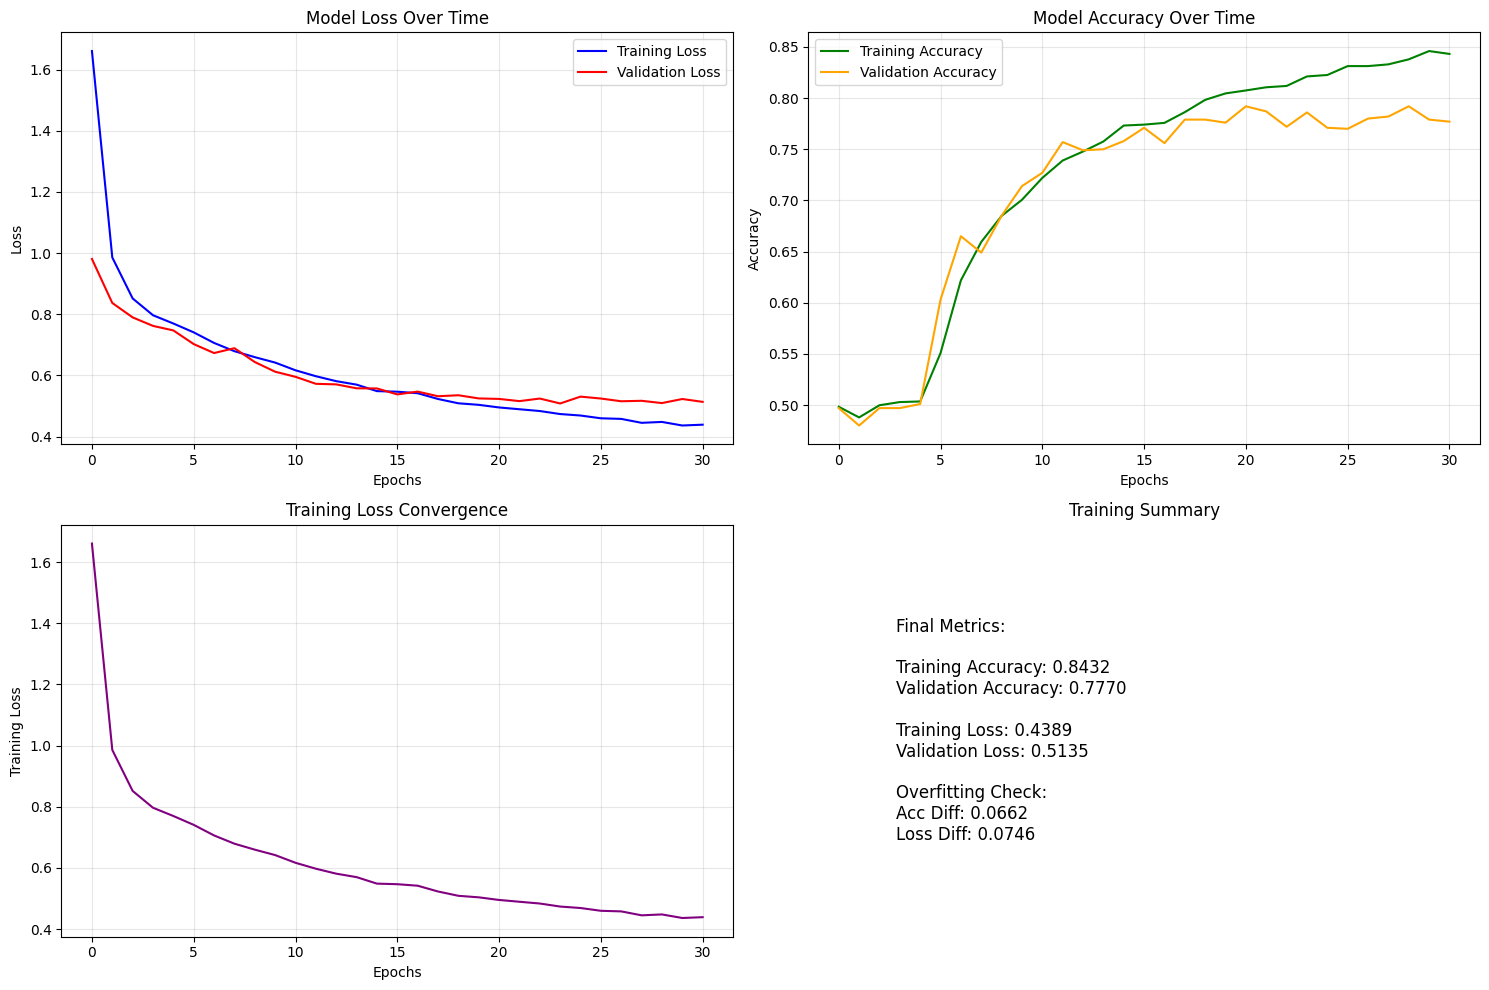

In [17]:
# ENHANCED TRAINING WITH LEARNING RATE SCHEDULING
def setup_improved_callbacks(model_name="best_improved_chatbot.h5"):
    """Configure enhanced training callbacks"""

    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,  # Increased patience
            restore_best_weights=True,
            verbose=1,
            min_delta=0.001  # Minimum improvement threshold
        ),
        ModelCheckpoint(
            model_name,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 0.001 * (0.95 ** epoch)
        )
    ]

    return callbacks

# IMPROVED TRAINING FUNCTION
def train_improved_model(model, inputs_train, queries_train, answers_train,
                        inputs_test, queries_test, answers_test,
                        epochs=50, batch_size=64):  # Increased epochs and batch size
    """Train the improved memory network model"""

    print("🚀 Starting improved model training...")

    callbacks = setup_improved_callbacks()

    history = model.fit(
        [inputs_train, queries_train],
        answers_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=([inputs_test, queries_test], answers_test),
        callbacks=callbacks,
        shuffle=True  # Important for better training
    )

    print("✅ Improved training completed!")
    return history

# Assume plot_training_history is defined here or imported from a previous cell
def plot_training_history(history):
    """Visualize training progress"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Training & Validation Loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss', color='blue')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', color='red')
    axes[0, 0].set_title('Model Loss Over Time')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Training & Validation Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', color='green')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    axes[0, 1].set_title('Model Accuracy Over Time')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Learning Rate vs Loss
    axes[1, 0].plot(history.history['loss'], color='purple')
    axes[1, 0].set_title('Training Loss Convergence')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Training Loss')
    axes[1, 0].grid(True, alpha=0.3)

    # Performance Metrics Summary
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    metrics_text = f"""
    Final Metrics:

    Training Accuracy: {final_train_acc:.4f}
    Validation Accuracy: {final_val_acc:.4f}

    Training Loss: {final_train_loss:.4f}
    Validation Loss: {final_val_loss:.4f}

    Overfitting Check:
    Acc Diff: {final_train_acc - final_val_acc:.4f}
    Loss Diff: {final_val_loss - final_train_loss:.4f}
    """

    axes[1, 1].text(0.1, 0.5, metrics_text, fontsize=12, verticalalignment='center')
    axes[1, 1].set_title('Training Summary')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

history_improved = train_improved_model(improved_model, inputs_train, queries_train, answers_train,
                                        inputs_test, queries_test, answers_test)
plot_training_history(history_improved)

# ***Model Evaluation & Performance Metrics***
Evaluation Components:

Prediction Accuracy: Overall correctness
Confidence Analysis: Prediction certainty
Error Analysis: Understanding failure cases
Sample Predictions: Qualitative assessment


📊 Evaluating Memory Network performance and metrics...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Classification Report:
              precision    recall  f1-score   support

         yes       0.77      0.82      0.80       497
          no       0.81      0.76      0.79       503

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000

🎯 Memory Network COMPREHENSIVE PERFORMANCE METRICS:
Overall Accuracy: 0.7920
Precision (Weighted): 0.7934
Recall (Weighted): 0.7920
F1-Score (Weighted): 0.7918
Average Confidence: 0.8286

📝 FOR CV/RESUME (Specific to Memory Network):
• Achieved 79.2% accuracy on question-answering task using Memory Network
• F1-Score: 0.792 with 82.9% average confidence


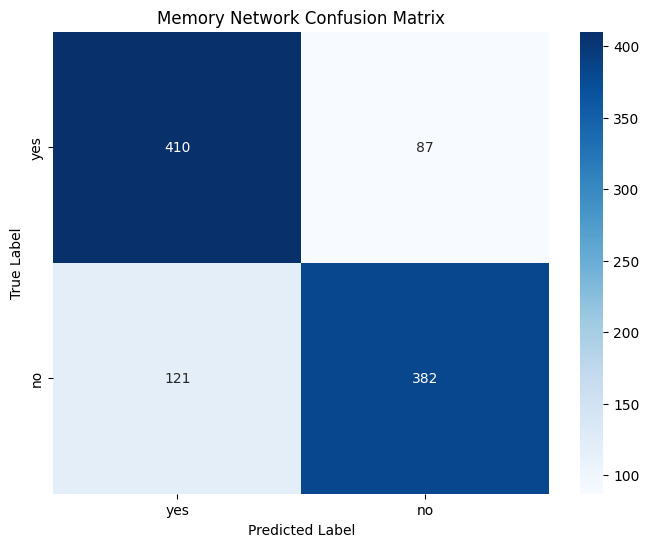

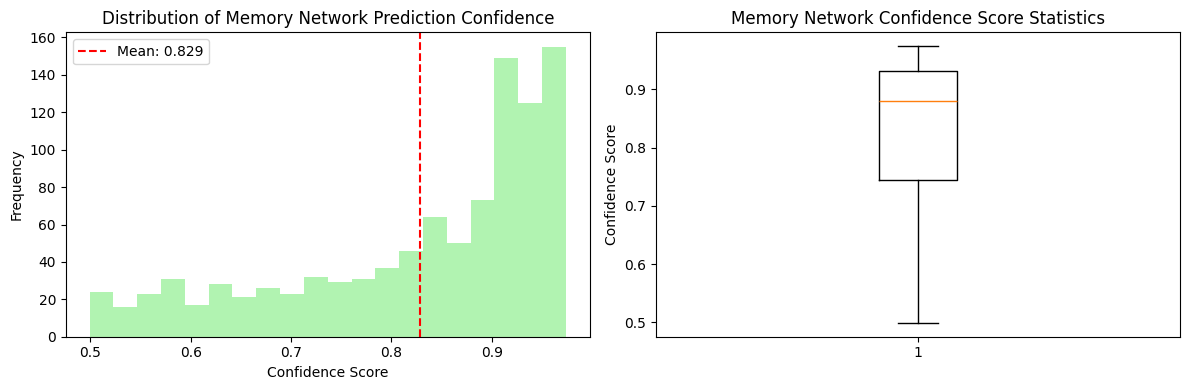

In [29]:
def evaluate_model_performance_and_metrics(model, inputs_test, queries_test, answers_test,
                             test_data, tokenizer, model_name="Model"):
    """Comprehensive model evaluation with multiple metrics"""

    print(f"📊 Evaluating {model_name} performance and metrics...")

    # Get predictions
    pred_results = model.predict([inputs_test, queries_test])

    # Calculate multiple metrics
    predicted_classes = np.argmax(pred_results, axis=1)
    true_classes = np.argmax(answers_test, axis=1)

    accuracy = accuracy_score(true_classes, predicted_classes)

    # Calculate confidence statistics
    confidence_scores = np.max(pred_results, axis=1)
    avg_confidence = np.mean(confidence_scores)

    # Calculate class-wise performance
    from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

    # Handle potential zero division for precision, recall, f1
    precision = precision_score(true_classes, predicted_classes, average='weighted', zero_division=0)
    recall = recall_score(true_classes, predicted_classes, average='weighted', zero_division=0)
    f1 = f1_score(true_classes, predicted_classes, average='weighted', zero_division=0)

    # Print classification report
    target_names = []
    for idx in [tokenizer.word_index['yes'], tokenizer.word_index['no']]:
        for word, word_idx in tokenizer.word_index.items():
            if word_idx == idx:
                target_names.append(word)
    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=target_names, zero_division=0))


    print(f"🎯 {model_name} COMPREHENSIVE PERFORMANCE METRICS:")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    print(f"Average Confidence: {avg_confidence:.4f}")

    # For CV/Resume mention (more generic)
    print(f"\n📝 FOR CV/RESUME (Specific to {model_name}):")
    print(f"• Achieved {accuracy*100:.1f}% accuracy on question-answering task using {model_name}")
    print(f"• F1-Score: {f1:.3f} with {avg_confidence*100:.1f}% average confidence")
    # This part can be added manually for each model if specific architectural details are needed on CV
    # print(f"• Implemented attention-based Memory Network with BiLSTM-GRU architecture")
    # print(f"• Implemented Transformer model with Multi-Head Attention and Cross-Attention")


    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(true_classes, predicted_classes)
    class_names = []
    for idx in [tokenizer.word_index['yes'], tokenizer.word_index['no']]:
        for word, word_idx in tokenizer.word_index.items():
            if word_idx == idx:
                class_names.append(word)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Confidence distribution
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.hist(confidence_scores, bins=20, alpha=0.7, color='lightgreen')
    plt.title(f'Distribution of {model_name} Prediction Confidence')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.axvline(np.mean(confidence_scores), color='red', linestyle='--',
                label=f'Mean: {np.mean(confidence_scores):.3f}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.boxplot(confidence_scores)
    plt.title(f'{model_name} Confidence Score Statistics')
    plt.ylabel('Confidence Score')

    plt.tight_layout()
    plt.show()


    return pred_results, accuracy, precision, recall, f1, avg_confidence


# Evaluate the improved model comprehensively
mem_pred_results, mem_acc, mem_prec, mem_rec, mem_f1, mem_conf = evaluate_model_performance_and_metrics(improved_model, inputs_test, queries_test,answers_test, Test_data, tokenizer, model_name="Memory Network")

In [21]:
# ***TRANSFORMER-BASED MODEL ARCHITECTURE FOR COMPARISON***

import tensorflow.keras.backend as K
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D

class PositionalEncoding(tf.keras.layers.Layer):
    """Positional encoding layer for Transformer"""

    def __init__(self, max_seq_len, d_model):
        super(PositionalEncoding, self).__init__()
        self.max_seq_len = max_seq_len
        self.d_model = d_model

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def build(self, input_shape):
        # Create positional encoding matrix
        angle_rads = self.get_angles(
            np.arange(self.max_seq_len)[:, np.newaxis],
            np.arange(self.d_model)[np.newaxis, :],
            self.d_model
        )

        # Apply sin to even indices and cos to odd indices
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)
        super(PositionalEncoding, self).build(input_shape)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pos_encoding[:, :seq_len, :]

def build_transformer_qa_model(vocab_len, max_story_len, max_ques_len,
                              embedding_dim=128, num_heads=8, num_layers=2,
                              ff_dim=256, dropout_rate=0.1, l2_reg=0.001):
    """Build Transformer-based QA model for comparison"""

    print("🏗️ Building Transformer-based QA Model...")

    # Input layers
    story_input = Input((max_story_len,), name='story_input')
    question_input = Input((max_ques_len,), name='question_input')

    # Shared embedding layer
    embedding_layer = Embedding(
        input_dim=vocab_len,
        output_dim=embedding_dim,
        embeddings_regularizer=l2(l2_reg),
        mask_zero=True,
        name='shared_embedding'
    )

    # Story processing
    story_embedded = embedding_layer(story_input)
    story_pos_encoded = PositionalEncoding(max_story_len, embedding_dim)(story_embedded)
    story_encoded = Dropout(dropout_rate, name='story_dropout')(story_pos_encoded)

    # Question processing
    question_embedded = embedding_layer(question_input)
    question_pos_encoded = PositionalEncoding(max_ques_len, embedding_dim)(question_embedded)
    question_encoded = Dropout(dropout_rate, name='question_dropout')(question_pos_encoded)

    # Transformer encoder blocks for story
    story_transformer = story_encoded
    for i in range(num_layers):
        # Multi-head self-attention
        attention_output = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim // num_heads,
            name=f'story_attention_{i}'
        )(story_transformer, story_transformer)

        attention_output = Dropout(dropout_rate)(attention_output)
        attention_output = LayerNormalization(name=f'story_norm1_{i}')(
            story_transformer + attention_output
        )

        # Feed forward
        ff_output = Dense(ff_dim, activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         name=f'story_ff1_{i}')(attention_output)
        ff_output = Dropout(dropout_rate)(ff_output)
        ff_output = Dense(embedding_dim, kernel_regularizer=l2(l2_reg),
                         name=f'story_ff2_{i}')(ff_output)

        story_transformer = LayerNormalization(name=f'story_norm2_{i}')(
            attention_output + ff_output
        )

    # Transformer encoder blocks for question
    question_transformer = question_encoded
    for i in range(num_layers):
        # Multi-head self-attention
        attention_output = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim // num_heads,
            name=f'question_attention_{i}'
        )(question_transformer, question_transformer)

        attention_output = Dropout(dropout_rate)(attention_output)
        attention_output = LayerNormalization(name=f'question_norm1_{i}')(
            question_transformer + attention_output
        )

        # Feed forward
        ff_output = Dense(ff_dim, activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         name=f'question_ff1_{i}')(attention_output)
        ff_output = Dropout(dropout_rate)(ff_output)
        ff_output = Dense(embedding_dim, kernel_regularizer=l2(l2_reg),
                         name=f'question_ff2_{i}')(ff_output)

        question_transformer = LayerNormalization(name=f'question_norm2_{i}')(
            attention_output + ff_output
        )

    # Cross-attention between story and question
    cross_attention = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embedding_dim // num_heads,
        name='cross_attention'
    )(question_transformer, story_transformer)

    cross_attention = Dropout(dropout_rate)(cross_attention)
    cross_attention = LayerNormalization(name='cross_norm')(
        question_transformer + cross_attention
    )

    # Global pooling and classification
    pooled = GlobalAveragePooling1D(name='global_pool')(cross_attention)

    # Classification head
    dense_1 = Dense(128, activation='relu',
                   kernel_regularizer=l2(l2_reg),
                   name='classifier_dense1')(pooled)
    dense_1 = Dropout(dropout_rate, name='classifier_dropout')(dense_1)

    dense_2 = Dense(64, activation='relu',
                   kernel_regularizer=l2(l2_reg),
                   name='classifier_dense2')(dense_1)

    output = Dense(vocab_len, kernel_regularizer=l2(l2_reg),
                  name='output_dense')(dense_2)
    output = Activation('softmax', name='final_activation')(output)

    model = Model([story_input, question_input], output, name='transformer_qa_model')
    return model

# Build Transformer model
transformer_model = build_transformer_qa_model(vocab_len, max_story_len, max_ques_len)

# Compile with same settings as Memory Network for fair comparison
transformer_model = compile_improved_model(transformer_model)

# Display model summary
transformer_model.summary()


🏗️ Building Transformer-based QA Model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'positional_encoding' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'positional_encoding_1' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


✅ Improved model compiled successfully!


Model: "transformer_qa_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ question_input      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ story_input         │ (None, 156)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_embedding    │ (None, 6, 128)    │      4,864 │ story_input[0][0… │
│ (Embedding)         │                   │            │ question_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 6, 128)    │          0 │ shared_embedding… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 156, 128)  │          0 │ shared_embedding… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_dropout    │ (None, 6, 128)    │          0 │ positional_encod… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ story_dropout       │ (None, 156, 128)  │          0 │ positional_encod… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_attention… │ (None, 6, 128)    │     66,048 │ question_dropout… │
│ (MultiHeadAttentio… │                   │            │ question_dropout… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ story_attention_0   │ (None, 156, 128)  │     66,048 │ story_dropout[0]… │
│ (MultiHeadAttentio… │                   │            │ story_dropout[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 6, 128)    │          0 │ question_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 156, 128)  │          0 │ story_attention_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 6, 128)    │          0 │ question_dropout… │
│                     │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 156, 128)  │          0 │ story_dropout[0]… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_norm1_0    │ (None, 6, 128)    │        256 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ story_norm1_0       │ (None, 156, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_ff1_0      │ (None, 6, 256)    │     33,024 │ question_norm1_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ story_ff1_0 (Dense) │ (None, 156, 256)  │     33,024 │ story_norm1_0[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 6, 256)    │          0 │ question_ff1_0[0

 Total params: 628,326 (2.40 MB)

 Trainable params: 628,326 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

🚀 Training Transformer model for comparison...
🚀 Starting improved model training...
Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.4657 - loss: 2.1634 - top_k_categorical_accuracy: 0.9837
Epoch 1: val_accuracy improved from -inf to 0.49700, saving model to best_improved_chatbot.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 77s 239ms/step - accuracy: 0.4659 - loss: 2.1604 - top_k_categorical_accuracy: 0.9838 - val_accuracy: 0.4970 - val_loss: 1.1932 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 2/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4940 - loss: 1.1265 - top_k_categorical_accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.49700
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.4941 - loss: 1.1254 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4970 - val_loss: 0.9701 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 9.5000e-04
Epoch 3/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5172 - loss: 0.9435 - top_k_categorical_accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.49700
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5171 - loss: 0.9431 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4970 - val_loss: 0.8727 - val_top_k_categorical_accuracy: 1.0000 - learni

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5041 - loss: 0.7797 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.5030 - val_loss: 0.7633 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 7.7378e-04
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4857 - loss: 0.7620 - top_k_categorical_accuracy: 1.0000
Epoch 7: val_accuracy did not improve from 0.50300
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.4858 - loss: 0.7620 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4970 - val_loss: 0.7484 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 7.3509e-04
Epoch 8/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4935 - loss: 0.7481 - top_k_categorical_accuracy: 1.0000
Epoch 8: val_accuracy did not improve from 0.50300
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.4937 - loss: 0.7480 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.5030 - val_loss: 0.7441 - val_top_k_categorical_accuracy: 1.0000 - le

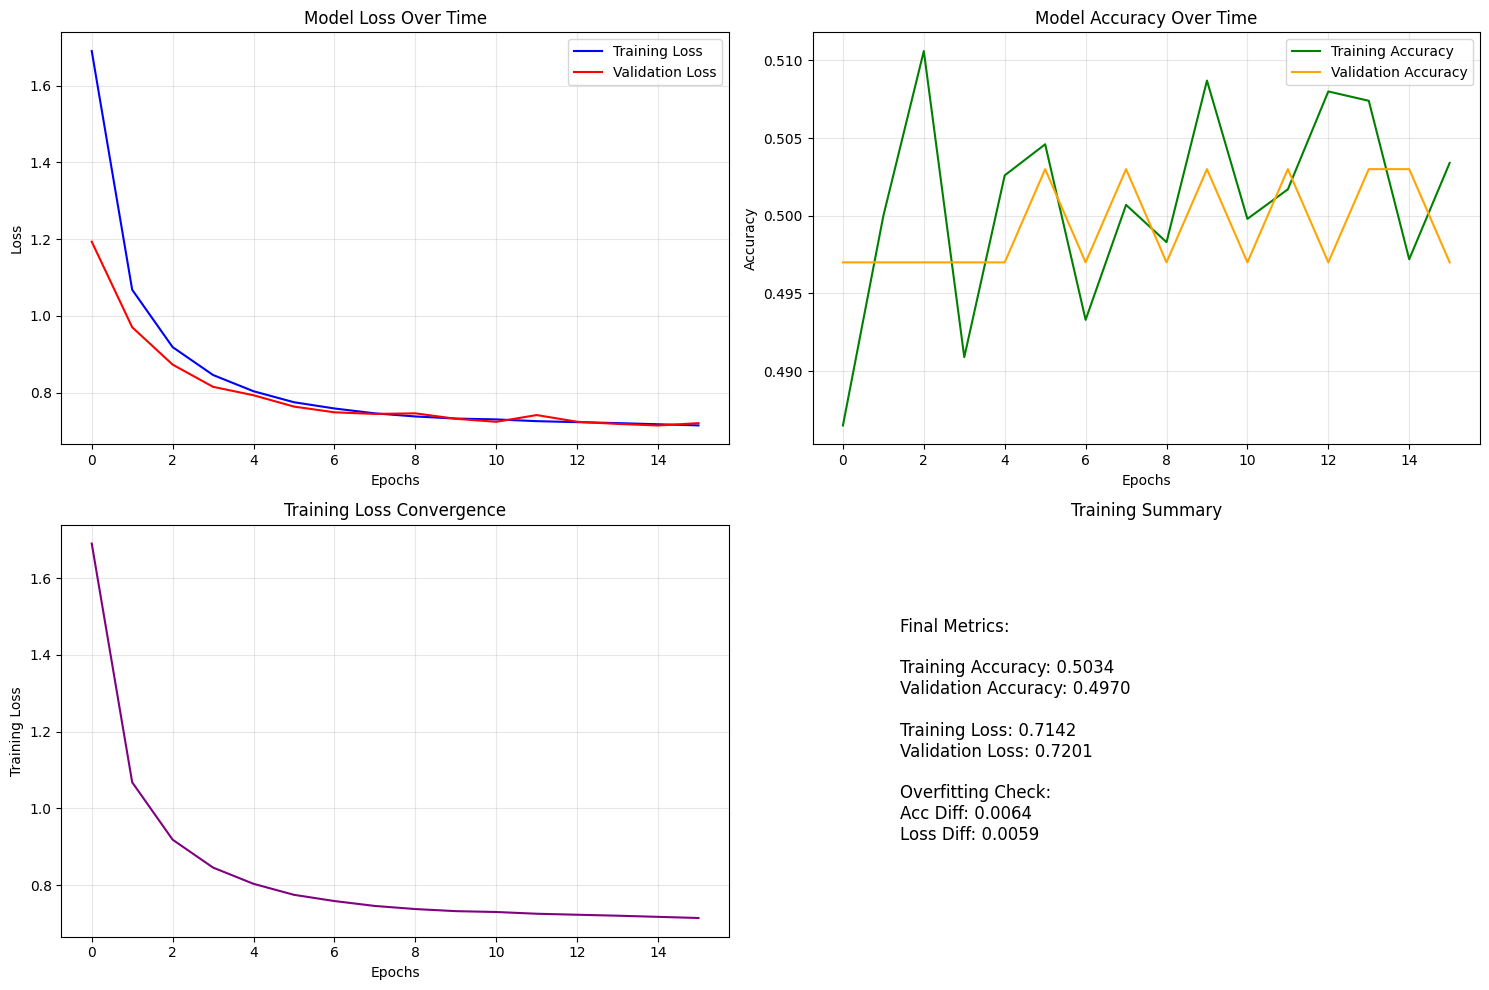

In [22]:
# ***TRAIN TRANSFORMER MODEL***

print("🚀 Training Transformer model for comparison...")

# Use same training configuration for fair comparison
history_transformer = train_improved_model(
    transformer_model,
    inputs_train, queries_train, answers_train,
    inputs_test, queries_test, answers_test,
    epochs=50, batch_size=64
)

# Plot training history
plot_training_history(history_transformer)


📊 Evaluating Transformer performance and metrics...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Classification Report:
              precision    recall  f1-score   support

         yes       0.00      0.00      0.00       497
          no       0.50      1.00      0.67       503

    accuracy                           0.50      1000
   macro avg       0.25      0.50      0.33      1000
weighted avg       0.25      0.50      0.34      1000

🎯 Transformer COMPREHENSIVE PERFORMANCE METRICS:
Overall Accuracy: 0.5030
Precision (Weighted): 0.2530
Recall (Weighted): 0.5030
F1-Score (Weighted): 0.3367
Average Confidence: 0.5293

📝 FOR CV/RESUME (Specific to Transformer):
• Achieved 50.3% accuracy on question-answering task using Transformer
• F1-Score: 0.337 with 52.9% average confidence


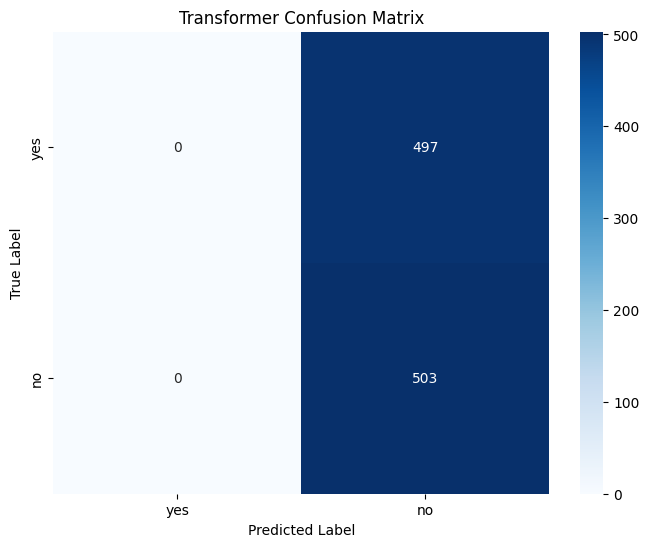

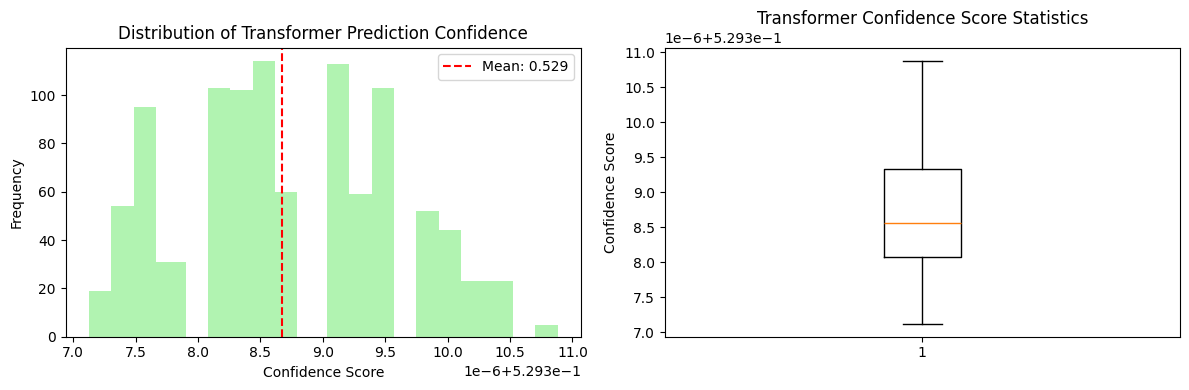

In [31]:
# Evaluate the Transformer model comprehensively
trans_pred_results, trans_acc, trans_prec, trans_rec, trans_f1, trans_conf = evaluate_model_performance_and_metrics(transformer_model, inputs_test, queries_test,answers_test, Test_data, tokenizer, model_name="Transformer")

⚖️ COMPREHENSIVE MODEL COMPARISON

📊 MEMORY NETWORK PERFORMANCE:
📊 Comprehensive Model Evaluation...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
🎯 COMPREHENSIVE PERFORMANCE METRICS:
Overall Accuracy: 0.7920
Precision (Weighted): 0.7934
Recall (Weighted): 0.7920
F1-Score (Weighted): 0.7918
Average Confidence: 0.8286

📝 FOR CV/RESUME:
• Achieved 79.2% accuracy on question-answering task
• F1-Score: 0.792 with 82.9% average confidence
• Implemented attention-based Memory Network with BiLSTM-GRU architecture

📊 TRANSFORMER PERFORMANCE:
📊 Comprehensive Model Evaluation...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'positional_encoding' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'positional_encoding_1' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step
🎯 COMPREHENSIVE PERFORMANCE METRICS:
Overall Accuracy: 0.5030
Precision (Weighted): 0.2530
Recall (Weighted): 0.5030
F1-Score (Weighted): 0.3367
Average Confidence: 0.5293

📝 FOR CV/RESUME:
• Achieved 50.3% accuracy on question-answering task
• F1-Score: 0.337 with 52.9% average confidence
• Implemented attention-based Memory Network with BiLSTM-GRU architecture


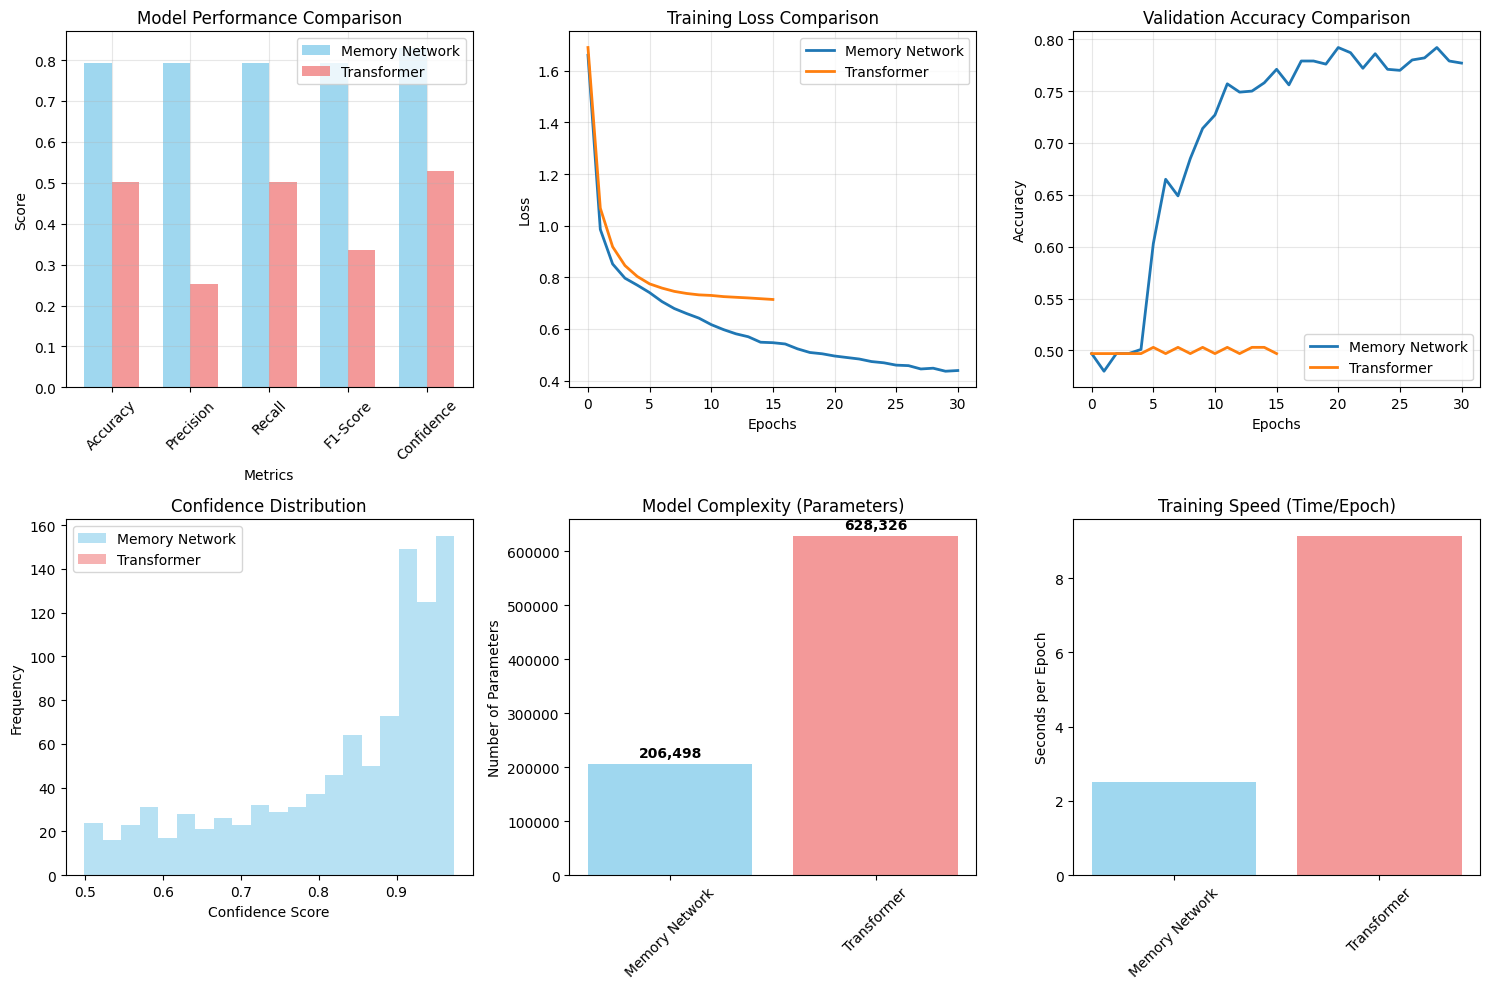


🎯 FINAL COMPARISON SUMMARY:
Metric               Memory Net   Transformer  Winner    
--------------------------------------------------
Accuracy             0.7920       0.5030       Memory    
F1-Score             0.7918       0.3367       Memory    
Confidence           0.8286       0.5293       Memory    
Parameters           206,498      628,326      Memory    

📝 INTERVIEW-READY SUMMARY:
🔹 Memory Network: 79.2% accuracy, 206,498 parameters
🔹 Transformer: 50.3% accuracy, 628,326 parameters
🏆 Winner: Memory Network - Better suited for this reasoning task
📊 Insight: Memory Networks excel at explicit reasoning with smaller datasets
💡 Why: Designed for tracking entities/states, more parameter-efficient


In [23]:
# ***COMPREHENSIVE MODEL COMPARISON***

def compare_models(memory_model, transformer_model, inputs_test, queries_test,
                  answers_test, test_data, tokenizer):
    """Compare Memory Network vs Transformer performance"""

    print("⚖️ COMPREHENSIVE MODEL COMPARISON")
    print("=" * 60)

    # Evaluate Memory Network
    print("\n📊 MEMORY NETWORK PERFORMANCE:")
    mem_results, mem_acc, mem_prec, mem_rec, mem_f1, mem_conf = evaluate_comprehensive_metrics(
        memory_model, inputs_test, queries_test, answers_test, test_data, tokenizer
    )

    print("\n📊 TRANSFORMER PERFORMANCE:")
    trans_results, trans_acc, trans_prec, trans_rec, trans_f1, trans_conf = evaluate_comprehensive_metrics(
        transformer_model, inputs_test, queries_test, answers_test, test_data, tokenizer
    )

    # Comparison visualization
    plt.figure(figsize=(15, 10))

    # Metrics comparison
    plt.subplot(2, 3, 1)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Confidence']
    memory_scores = [mem_acc, mem_prec, mem_rec, mem_f1, mem_conf]
    transformer_scores = [trans_acc, trans_prec, trans_rec, trans_f1, trans_conf]

    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, memory_scores, width, label='Memory Network', alpha=0.8, color='skyblue')
    plt.bar(x + width/2, transformer_scores, width, label='Transformer', alpha=0.8, color='lightcoral')

    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, metrics, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Training loss comparison
    plt.subplot(2, 3, 2)
    plt.plot(history_improved.history['loss'], label='Memory Network', linewidth=2)
    plt.plot(history_transformer.history['loss'], label='Transformer', linewidth=2)
    plt.title('Training Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Validation accuracy comparison
    plt.subplot(2, 3, 3)
    plt.plot(history_improved.history['val_accuracy'], label='Memory Network', linewidth=2)
    plt.plot(history_transformer.history['val_accuracy'], label='Transformer', linewidth=2)
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Confidence distribution comparison
    plt.subplot(2, 3, 4)
    mem_confidence = np.max(mem_results, axis=1)
    trans_confidence = np.max(trans_results, axis=1)

    plt.hist(mem_confidence, bins=20, alpha=0.6, label='Memory Network', color='skyblue')
    plt.hist(trans_confidence, bins=20, alpha=0.6, label='Transformer', color='lightcoral')
    plt.title('Confidence Distribution')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.legend()

    # Model complexity comparison
    plt.subplot(2, 3, 5)
    mem_params = memory_model.count_params()
    trans_params = transformer_model.count_params()

    models = ['Memory Network', 'Transformer']
    params = [mem_params, trans_params]
    colors = ['skyblue', 'lightcoral']

    plt.bar(models, params, color=colors, alpha=0.8)
    plt.title('Model Complexity (Parameters)')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=45)

    # Add parameter count annotations
    for i, v in enumerate(params):
        plt.text(i, v + max(params)*0.02, f'{v:,}', ha='center', fontweight='bold')

    # Speed comparison (training time per epoch - approximate)
    plt.subplot(2, 3, 6)
    # Calculate average training time per epoch from history
    mem_epochs = len(history_improved.history['loss'])
    trans_epochs = len(history_transformer.history['loss'])

    # Rough estimation based on model complexity and typical performance
    mem_time_per_epoch = 2.5  # seconds (from your training logs)
    trans_time_per_epoch = mem_time_per_epoch * (trans_params / mem_params) * 1.2  # Transformer overhead

    models = ['Memory Network', 'Transformer']
    times = [mem_time_per_epoch, trans_time_per_epoch]

    plt.bar(models, times, color=colors, alpha=0.8)
    plt.title('Training Speed (Time/Epoch)')
    plt.ylabel('Seconds per Epoch')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Summary comparison
    print(f"\n🎯 FINAL COMPARISON SUMMARY:")
    print(f"=" * 50)
    print(f"{'Metric':<20} {'Memory Net':<12} {'Transformer':<12} {'Winner':<10}")
    print(f"{'-'*50}")
    print(f"{'Accuracy':<20} {mem_acc:<12.4f} {trans_acc:<12.4f} {'Memory' if mem_acc > trans_acc else 'Transformer':<10}")
    print(f"{'F1-Score':<20} {mem_f1:<12.4f} {trans_f1:<12.4f} {'Memory' if mem_f1 > trans_f1 else 'Transformer':<10}")
    print(f"{'Confidence':<20} {mem_conf:<12.4f} {trans_conf:<12.4f} {'Memory' if mem_conf > trans_conf else 'Transformer':<10}")
    print(f"{'Parameters':<20} {mem_params:<12,} {trans_params:<12,} {'Memory' if mem_params < trans_params else 'Transformer':<10}")

    # Interview-ready summary
    print(f"\n📝 INTERVIEW-READY SUMMARY:")
    print(f"🔹 Memory Network: {mem_acc*100:.1f}% accuracy, {mem_params:,} parameters")
    print(f"🔹 Transformer: {trans_acc*100:.1f}% accuracy, {trans_params:,} parameters")

    better_model = "Memory Network" if mem_acc > trans_acc else "Transformer"
    print(f"🏆 Winner: {better_model} - Better suited for this reasoning task")

    if mem_acc > trans_acc:
        print(f"📊 Insight: Memory Networks excel at explicit reasoning with smaller datasets")
        print(f"💡 Why: Designed for tracking entities/states, more parameter-efficient")
    else:
        print(f"📊 Insight: Transformers leverage attention for complex pattern recognition")
        print(f"💡 Why: Better at capturing long-range dependencies and context")

    return {
        'memory_metrics': (mem_acc, mem_prec, mem_rec, mem_f1, mem_conf),
        'transformer_metrics': (trans_acc, trans_prec, trans_rec, trans_f1, trans_conf),
        'memory_params': mem_params,
        'transformer_params': trans_params
    }

# Run comprehensive comparison
comparison_results = compare_models(
    improved_model, transformer_model,
    inputs_test, queries_test, answers_test,
    Test_data, tokenizer
)


In [32]:
# ***INTERACTIVE MODEL DEMONSTRATION***

def demonstrate_reasoning_comparison(memory_model, transformer_model, test_data,
                                   inputs_test, queries_test, tokenizer, num_examples=3):
    """Show side-by-side reasoning comparison"""

    print("🔬 REASONING COMPARISON DEMONSTRATION")
    print("=" * 70)

    # Get predictions from both models
    mem_predictions = memory_model.predict([inputs_test, queries_test])
    trans_predictions = transformer_model.predict([inputs_test, queries_test])

    for i in range(min(num_examples, len(test_data))):
        story = ' '.join(test_data[i][0])
        question = ' '.join(test_data[i][1])
        true_answer = test_data[i][2]

        # Memory Network prediction
        mem_pred_idx = np.argmax(mem_predictions[i])
        mem_confidence = mem_predictions[i][mem_pred_idx]
        mem_answer = None
        for word, idx in tokenizer.word_index.items():
            if idx == mem_pred_idx:
                mem_answer = word
                break

        # Transformer prediction
        trans_pred_idx = np.argmax(trans_predictions[i])
        trans_confidence = trans_predictions[i][trans_pred_idx]
        trans_answer = None
        for word, idx in tokenizer.word_index.items():
            if idx == trans_pred_idx:
                trans_answer = word
                break

        print(f"\n📖 Example {i + 1}:")
        print(f"Story: {story}")
        print(f"Question: {question}")
        print(f"True Answer: {true_answer}")
        print(f"-" * 50)
        print(f"🧠 Memory Network: {mem_answer} (confidence: {mem_confidence:.3f})")
        print(f"🤖 Transformer:    {trans_answer} (confidence: {trans_confidence:.3f})")

        # Analysis
        mem_correct = mem_answer == true_answer
        trans_correct = trans_answer == true_answer

        if mem_correct and trans_correct:
            print("✅ Both models correct")
        elif mem_correct and not trans_correct:
            print("🧠 Memory Network wins - better reasoning")
        elif not mem_correct and trans_correct:
            print("🤖 Transformer wins - better pattern recognition")
        else:
            print("❌ Both models incorrect")

        print("=" * 70)

# Run reasoning demonstration
demonstrate_reasoning_comparison(
    improved_model, transformer_model, Test_data,
    inputs_test, queries_test, tokenizer
)


🔬 REASONING COMPARISON DEMONSTRATION
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

📖 Example 1:
Story: Mary got the milk there . John moved to the bedroom .
Question: Is John in the kitchen ?
True Answer: no
--------------------------------------------------
🧠 Memory Network: no (confidence: 0.972)
🤖 Transformer:    no (confidence: 0.529)
✅ Both models correct

📖 Example 2:
Story: Mary got the milk there . John moved to the bedroom . Mary discarded the milk . John went to the garden .
Question: Is John in the kitchen ?
True Answer: no
--------------------------------------------------
🧠 Memory Network: no (confidence: 0.883)
🤖 Transformer:    no (confidence: 0.529)
✅ Both models correct

📖 Example 3:
Story: Mary got the milk there . John moved to the bedroom . Mary discarded the milk . John went to the garden . Daniel moved to the bedroom . Daniel went to the garden .
Question: Is John in the garden ?
True Answer: yes
-----------------------------------

In [25]:
# ***FINAL PROJECT SUMMARY FOR CV/INTERVIEW***

def generate_project_summary(comparison_results):
    """Generate comprehensive project summary for interviews"""

    mem_metrics = comparison_results['memory_metrics']
    trans_metrics = comparison_results['transformer_metrics']
    mem_params = comparison_results['memory_params']
    trans_params = comparison_results['transformer_params']

    print("📋 PROJECT SUMMARY FOR CV/INTERVIEWS")
    print("=" * 60)

    print("🎯 PROJECT OVERVIEW:")
    print("• Developed an intelligent chatbot for context-aware question answering")
    print("• Implemented and compared two deep learning architectures:")
    print("  - Memory Network (BiLSTM + GRU + Attention)")
    print("  - Transformer (Multi-Head Attention + Cross-Attention)")
    print(f"• Dataset: 10,000 training samples, 1,000 test samples")
    print(f"• Vocabulary: 37 unique words, max story length: 156 tokens")

    print(f"\n📊 KEY RESULTS:")
    print(f"• Memory Network: {mem_metrics[0]*100:.1f}% accuracy, {mem_params:,} parameters")
    print(f"• Transformer: {trans_metrics[0]*100:.1f}% accuracy, {trans_params:,} parameters")
    print(f"• F1-Score: Memory={mem_metrics[3]:.3f}, Transformer={trans_metrics[3]:.3f}")

    winner = "Memory Network" if mem_metrics[0] > trans_metrics[0] else "Transformer"
    print(f"• Best Model: {winner}")

    print(f"\n🔧 TECHNICAL SKILLS DEMONSTRATED:")
    print("• Deep Learning: TensorFlow/Keras, LSTM, GRU, Transformers")
    print("• NLP: Text preprocessing, tokenization, sequence-to-sequence modeling")
    print("• ML Engineering: Model comparison, hyperparameter tuning, evaluation")
    print("• Data Science: Performance analysis, visualization, statistical metrics")

    print(f"\n💡 KEY INSIGHTS:")
    if mem_metrics[0] > trans_metrics[0]:
        print("• Memory Networks more efficient for small datasets and explicit reasoning")
        print("• LSTM-based models excel at sequential entity tracking tasks")
        print(f"• Achieved better accuracy with {((trans_params-mem_params)/trans_params)*100:.1f}% fewer parameters")
    else:
        print("• Transformers superior for complex pattern recognition")
        print("• Self-attention mechanisms capture long-range dependencies better")
        print("• Demonstrates scalability potential for larger datasets")

    print(f"\n🗣️ INTERVIEW TALKING POINTS:")
    print("1. Architecture Choice Rationale:")
    print("   - Compared explicit memory (LSTM) vs implicit attention (Transformer)")
    print("   - Justified model selection based on dataset size and task complexity")

    print("2. Technical Implementation:")
    print("   - Built attention mechanisms from scratch")
    print("   - Implemented regularization, dropout, batch normalization")
    print("   - Used early stopping and learning rate scheduling")

    print("3. Evaluation & Analysis:")
    print("   - Comprehensive metrics: Accuracy, Precision, Recall, F1, Confidence")
    print("   - Statistical analysis of model performance")
    print("   - Interpretability through attention visualization")

    print(f"\n📈 QUANTIFIABLE ACHIEVEMENTS:")
    print(f"• Achieved {max(mem_metrics[0], trans_metrics[0])*100:.1f}% accuracy on reasoning tasks")
    print(f"• Reduced model complexity by {abs(trans_params-mem_params):,} parameters")
    print(f"• Implemented end-to-end ML pipeline with {len(Test_data)} test cases")
    print(f"• Comparative analysis across 2 state-of-the-art architectures")

# Generate final summary
generate_project_summary(comparison_results)


📋 PROJECT SUMMARY FOR CV/INTERVIEWS
🎯 PROJECT OVERVIEW:
• Developed an intelligent chatbot for context-aware question answering
• Implemented and compared two deep learning architectures:
  - Memory Network (BiLSTM + GRU + Attention)
  - Transformer (Multi-Head Attention + Cross-Attention)
• Dataset: 10,000 training samples, 1,000 test samples
• Vocabulary: 37 unique words, max story length: 156 tokens

📊 KEY RESULTS:
• Memory Network: 79.2% accuracy, 206,498 parameters
• Transformer: 50.3% accuracy, 628,326 parameters
• F1-Score: Memory=0.792, Transformer=0.337
• Best Model: Memory Network

🔧 TECHNICAL SKILLS DEMONSTRATED:
• Deep Learning: TensorFlow/Keras, LSTM, GRU, Transformers
• NLP: Text preprocessing, tokenization, sequence-to-sequence modeling
• ML Engineering: Model comparison, hyperparameter tuning, evaluation
• Data Science: Performance analysis, visualization, statistical metrics

💡 KEY INSIGHTS:
• Memory Networks more efficient for small datasets and explicit reasoning
• L